In [ ]:
# !!!!!!!!!! TO-DO +++++++
# X) scale hh and qcd inputs coherently --> thanks colby
# X) make 2D latent plots?
# 1) consider whittling down hard-to-model inputs e.g. nJets
# X) bdt_data_train is the input to use for BDT. borrow structure from k-means study by Ang
# 2) what do delta-function latent variables mean?
# 3) what does high accuracy and low loss mean here? seems like modelling is poor but ..?
# 4) make residual plots to determine poorly modeled variables
# 5) start drafting slides to identify holes
# 6) ...
# N) make benchmark BSM -> 4b model for comparison

In [66]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization
from keras.regularizers import l2, l1
from keras.utils import normalize, to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, auc, roc_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import keras as keras
import seaborn as sns
import xgboost as xgb

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

In [3]:
# *** 1. Import data and check stuff
testingFraction = 0.3

In [4]:
# ** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

Dihiggs file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_500kEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv
QCD file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_2MEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv


In [5]:
# ** B. Make testing and training samples
variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'jet2_eta', 'jet3_eta', 
             'nJets', 'jet3_pz', 'jet4_eta', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'scalarHT', 'deltaPhi(h1, h2)', 
             'deltaPhi(h1 jets)', 'jet4_pt', 'jet2_pt', 'jet1_pz', 'jet1_pt', 'jet1_mass']

#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'jet2_eta', 'jet3_eta', 
#             'nJets', 'jet3_pz', 'jet4_eta', 'h1_mass']
data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, 
                                                                                         variables, testingFraction)

#data_hh_train, data_hh_test, labels_hh_train, labels_hh_test = makeTestTrainSamplesWithUserVariables(hh_raw[hh_raw.isSignal==1], 
#                                                                             qcd_raw[qcd_raw.isSignal==1], 
#                                                                             variables, testingFraction)

# ** C. Apply normalization to make 0mean/1sigma data inputs
#sc = StandarScaler()

sc = MinMaxScaler()
data_train__norm = sc.fit_transform(data_train)
data_test__norm = sc.fit_transform(data_test)


# ** D. Split into qcd (training) and hh ("anomaly")
# add labels
data_train__norm = np.concatenate((data_train__norm, labels_train), 1)
data_test__norm  = np.concatenate((data_test__norm, labels_test), 1)

# make qcd training set and separated testing sets
data_train__norm    = data_train__norm[data_train__norm[:,-1]==0] # training with qcd only
data_hh_test__norm  = data_test__norm[data_test__norm[:,-1]==1] # testing with dihiggs only
data_qcd_test__norm = data_test__norm[data_test__norm[:,-1]==0] # testing with qcd only
labels_hh_test      = labels_test[data_test__norm[:,-1]==1] # testing with dihiggs only
labels_qcd_test     = labels_test[data_test__norm[:,-1]==0] # testing with qcd only

# drop 'isSignal' from sets
data_train__norm    = np.delete(data_train__norm, -1, 1)
data_test__norm     = np.delete(data_test__norm, -1, 1)
data_qcd_test__norm = np.delete(data_qcd_test__norm, -1, 1)
data_hh_test__norm  = np.delete(data_hh_test__norm, -1, 1)

#print(len(data_train__norm[0]), len(data_qcd_test__norm[0]), len(data_hh_test__norm[0]), len(data_train.columns))

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [14]:
# *** 2. Setup auto-encoder network structure
def newAutoEncoder( _compiler, _data_columns, _encodingDimensions=21, _loss='binary_crossentropy'):
    """function so you don't have to re-run everything everytime"""

    l2_reg = l2(0.01)
    #l2_reg = l1(0.1)
    
    # Size of our encoded representataion -> compression of factor _encodingDimensions / len(data_columns)
    print(_data_columns.shape)
    
    # size of hidden layer between input/output and latent
    _intermediaryDimensions = _data_columns.shape[0]*2
    
    # Input placeholder
    _input_img = Input(shape = _data_columns.shape )
    # "encoded" is the encoded representation of the input
    #_encoded = Dense(_encodingDimensions, activation='relu')(_input_img) # relu ORIGINAL
    
    _encoded = Dense(_intermediaryDimensions, activation='relu')(_input_img) # relu ORIGINAL
    #_encoded = Dropout(0.1)(_encoded) # relu ORIGINAL
    _encoded = Dense(_encodingDimensions, activation='relu')(_encoded) # tanh BBT

    
    # "decoded" is the lossy reconstruction of the input
    #_decoded = Dense( _data_columns.shape[0], activation='linear')(_encoded) # sigmoid # ORIGINAL
    
    _decoded = Dense( _intermediaryDimensions, activation='relu')(_encoded) # relu or tanh BBT
    _decoded = Dense( _data_columns.shape[0], activation='sigmoid')(_decoded) # linear BBT

    # this model maps an input to its reconstruction
    _autoencoder = Model(_input_img, _decoded)

    # this model maps an input to its encoded representation
    _encoder = Model(_input_img, _encoded)

    """
    # create a placeholder for an encoded (32-dimensional) input
    _encoded_input = Input(shape=(_encodingDimensions,))
    # retrieve the last layer of the autoencoder model
    _decoder_layer = _autoencoder.layers[-1]
    # create the decoder model
    #_decoder = Model(_encoded_input, _decoder_layer(_encoded_input)) # ORIGINAL
    _decoder = Model(_intermediaryDimensions, _decoder_layer(_encoded_input))
    """
    
    _loss = 'mse'
    _autoencoder.compile(optimizer=_compiler, loss=_loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    
    #return _autoencoder, _encoder, _decoder
    return _autoencoder, _encoder


# compile the model
#_copiler = 'adadelta'
_compiler = 'adam'
encodedDimensions = 15
#encodedDimensions = data_train.columns.shape[0] # "identity" encoder
autoencoder, encoder = newAutoEncoder( _compiler, data_train.columns, 
                                      _encodingDimensions=encodedDimensions)

autoencoder.summary()

(21,)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 42)                924       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                645       
_________________________________________________________________
dense_7 (Dense)              (None, 42)                672       
_________________________________________________________________
dense_8 (Dense)              (None, 21)                903       
Total params: 3,144
Trainable params: 3,144
Non-trainable params: 0
_________________________________________________________________


In [106]:
# *** 3. Train the model
history = autoencoder.fit(data_train__norm, data_train__norm,
                          #data_train, data_train,
                          epochs=50,
                          batch_size=512,
                          shuffle=True,
                          validation_data=(data_test__norm, data_test__norm))

Train on 81597 samples, validate on 58608 samples
Epoch 1/50
81597/81597 [==============================] - 7s 80us/step - loss: 0.0013 - accuracy: 0.9105 - auc: 0.6985 - val_loss: 0.0023 - val_accuracy: 0.8755 - val_auc: 0.7084
Epoch 2/50
81597/81597 [==============================] - 7s 80us/step - loss: 0.0013 - accuracy: 0.9122 - auc: 0.7176 - val_loss: 0.0023 - val_accuracy: 0.8736 - val_auc: 0.7261
Epoch 3/50
81597/81597 [==============================] - 6s 79us/step - loss: 0.0012 - accuracy: 0.9138 - auc: 0.7340 - val_loss: 0.0021 - val_accuracy: 0.8767 - val_auc: 0.7415
Epoch 4/50
81597/81597 [==============================] - 6s 76us/step - loss: 0.0010 - accuracy: 0.9160 - auc: 0.7484 - val_loss: 0.0019 - val_accuracy: 0.8796 - val_auc: 0.7548
Epoch 5/50
81597/81597 [==============================] - 7s 87us/step - loss: 9.5786e-04 - accuracy: 0.9164 - auc: 0.7606 - val_loss: 0.0018 - val_accuracy: 0.8794 - val_auc: 0.7663
Epoch 6/50
81597/81597 [===========================

Epoch 45/50
81597/81597 [==============================] - 6s 77us/step - loss: 2.9518e-04 - accuracy: 0.9338 - auc: 0.8854 - val_loss: 6.9944e-04 - val_accuracy: 0.9171 - val_auc: 0.8862
Epoch 46/50
81597/81597 [==============================] - 6s 75us/step - loss: 2.9260e-04 - accuracy: 0.9340 - auc: 0.8870 - val_loss: 6.8425e-04 - val_accuracy: 0.9180 - val_auc: 0.8879
Epoch 47/50
81597/81597 [==============================] - 6s 78us/step - loss: 2.8918e-04 - accuracy: 0.9342 - auc: 0.8887 - val_loss: 6.8458e-04 - val_accuracy: 0.9179 - val_auc: 0.8895
Epoch 48/50
81597/81597 [==============================] - 7s 80us/step - loss: 2.8697e-04 - accuracy: 0.9339 - auc: 0.8903 - val_loss: 6.9991e-04 - val_accuracy: 0.9164 - val_auc: 0.8911
Epoch 49/50
81597/81597 [==============================] - 6s 79us/step - loss: 2.8468e-04 - accuracy: 0.9343 - auc: 0.8918 - val_loss: 6.7128e-04 - val_accuracy: 0.9172 - val_auc: 0.8926
Epoch 50/50
81597/81597 [==============================] - 7

In [107]:
# *** 4. Evaluate results
# encode and decode some events ~~~! note that tests taken from ... test set
encoded_imgs = encoder.predict(data_qcd_test__norm)
encoded_hh_imgs = encoder.predict(data_hh_test__norm)

#decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(data_qcd_test__norm)
decoded_hh_imgs = autoencoder.predict(data_hh_test__norm)

dict_keys(['val_loss', 'val_accuracy', 'val_auc', 'loss', 'accuracy', 'auc'])


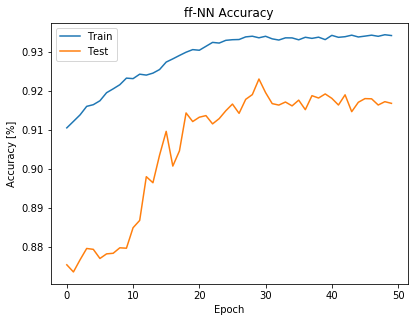

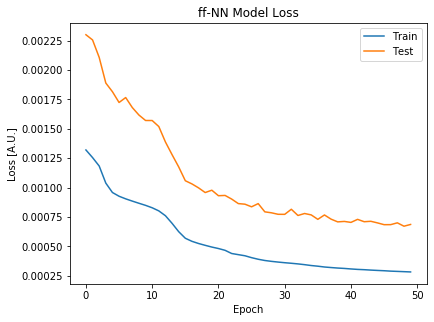

In [108]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ff-NN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ff-NN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()



(array([3183., 3208., 1587., 1176.,  912.,  855.,  745.,  793.,  865.,
        1140., 1417., 1841., 2105., 2598., 3033., 3312., 2344., 1409.,
         954.,  616.,  386.,  208.,  123.,   60.,   14.]),
 array([0.04209435, 0.0763109 , 0.11052746, 0.14474401, 0.17896056,
        0.21317711, 0.24739367, 0.28161022, 0.31582677, 0.35004333,
        0.38425988, 0.41847643, 0.452693  , 0.48690957, 0.5211261 ,
        0.5553427 , 0.5895592 , 0.6237758 , 0.6579923 , 0.6922089 ,
        0.7264254 , 0.760642  , 0.7948585 , 0.8290751 , 0.8632916 ,
        0.8975082 ], dtype=float32),
 <a list of 25 Patch objects>)

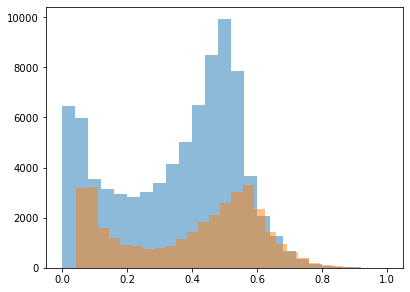

In [109]:
#plt.hist(encoded_imgs[:,0], bins=25, alpha=0.5)
#plt.hist(decoded_imgs[:,4], bins=25, alpha=0.5)

plt.hist(data_train__norm[:,1], bins = 25, alpha=0.5)
plt.hist(decoded_imgs[:,1], bins=25, alpha=0.5)


In [110]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 42)                924       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                645       
_________________________________________________________________
dense_7 (Dense)              (None, 42)                672       
_________________________________________________________________
dense_8 (Dense)              (None, 21)                903       
Total params: 3,144
Trainable params: 3,144
Non-trainable params: 0
_________________________________________________________________


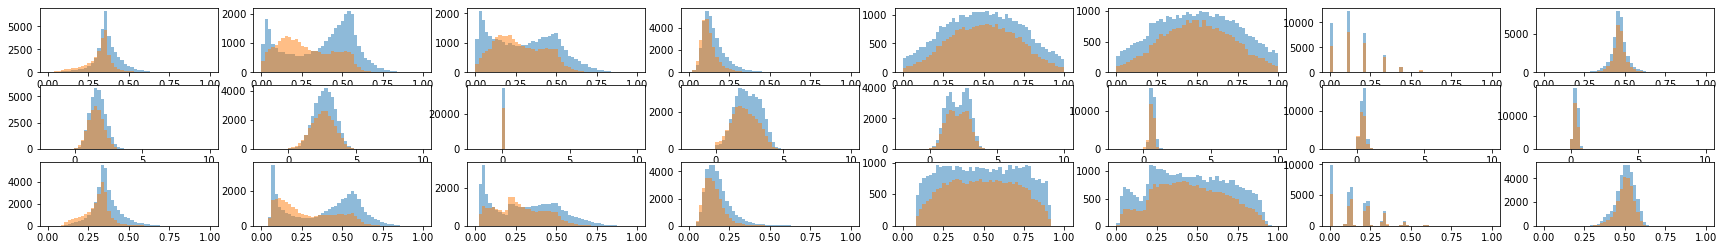

In [111]:
n = 8  # how many digits we will display
#nBins = 25
#nBins = np.linspace(min(data_train__norm[:,0]), max(data_train__norm[:,0]), 25)
nBins = np.linspace(0, 1, 50)
nBins2 = np.linspace(-2, 10, 50)
plt.figure(figsize=(30, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.hist(data_qcd_test__norm[:,i], bins=nBins, alpha=0.5)
    plt.hist(data_hh_test__norm[:,i], bins=nBins, alpha=0.5)
   
    # display latent
    ax = plt.subplot(3, n, i + 1 + n)
    if i < (encodedDimensions) :
        plt.hist(encoded_imgs[:, i], bins=nBins2, alpha=0.5)
        plt.hist(encoded_hh_imgs[:, i], bins=nBins2, alpha=0.5)
        #plt.hist(encoded_imgs[:,min(i, encodedDimensions-1)], bins=nBins2, alpha=0.5)
        #plt.hist(encoded_hh_imgs[:,min(i, encodedDimensions-1)], bins=nBins2, alpha=0.5)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.hist(decoded_imgs[:,i], bins=nBins, alpha=0.5)
    plt.hist(decoded_hh_imgs[:,i], bins=nBins, alpha=0.5)

    
plt.show()

(array([3.3000e+01, 8.4000e+01, 1.3800e+02, 2.2900e+02, 3.0900e+02,
        3.6700e+02, 4.4300e+02, 5.2700e+02, 6.8500e+02, 8.4600e+02,
        1.2100e+03, 1.7080e+03, 2.7120e+03, 4.5420e+03, 8.0650e+03,
        1.5097e+04, 1.3717e+04, 8.2210e+03, 6.1290e+03, 4.4540e+03,
        3.2920e+03, 2.5700e+03, 1.8460e+03, 1.3630e+03, 8.8400e+02,
        6.6300e+02, 4.8200e+02, 3.0300e+02, 1.8200e+02, 1.3600e+02,
        1.2000e+02, 5.3000e+01, 5.3000e+01, 3.0000e+01, 3.6000e+01,
        2.1000e+01, 1.5000e+01, 7.0000e+00, 9.0000e+00, 2.0000e+00,
        6.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.

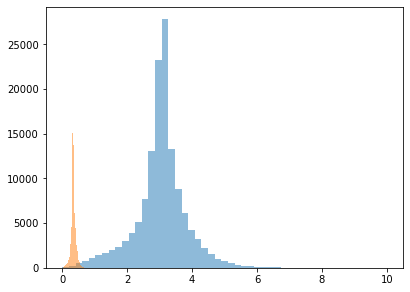

In [112]:
nBins3 = np.linspace(0, 1, 50)
nBins4 = np.linspace(0, 10, 50)

plt.hist(data_train['deltaR(h1, h2)'], bins=nBins4, alpha=0.5)
plt.hist(data_train__norm[:,0], bins=nBins3, alpha=0.5)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 9.900e+01, 3.430e+02, 8.550e+02, 1.731e+03,
        2.801e+03, 3.703e+03, 4.091e+03, 3.729e+03, 2.820e+03, 1.823e+03,
        1.002e+03, 4.960e+02, 1.670e+02, 4.600e+01, 1.700e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([-2.        , -1.75510204, -1.51020408, -1.26530612, -1.02040816,
        -0.7755102 , -0.53061224, -0.28571429, -0.04081633,  0.20408163,
         0.44897959,  0.69387755,  0.93877551,  1.18367347,  1.42857143,
         1.67346939,  1.91836735,  2.16326531,  2.40816327,  2.65306122,
         2.89795918,  3.14285714,  3.3877551 ,  3.63265306,  3.87755102,
         4.12244898,  

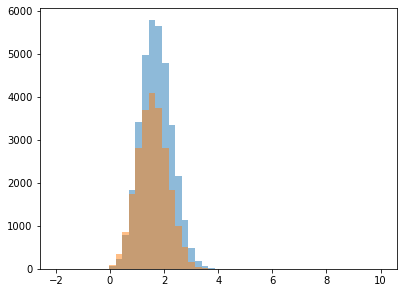

In [113]:
plt.hist(encoded_imgs[:,0], bins=nBins2, alpha=0.5)
plt.hist(encoded_hh_imgs[:,0], bins=nBins2, alpha=0.5)


In [114]:
def jointPlots( _hh_imgs, _qcd_imgs, _latentVar1, _latentVar2):
    sns.jointplot(x=_hh_imgs[:,_latentVar1], y=_hh_imgs[:,_latentVar2], kind='hex')
    plt.show()

    sns.jointplot(x=_qcd_imgs[:,_latentVar1], y=_qcd_imgs[:,_latentVar2], kind='hex')
    plt.show()

#plt.scatter(encoded_hh_imgs[:,0], encoded_hh_imgs[:,1])
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,1], kind='hex')
#plt.show()
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,2], kind='hex')
#plt.show()
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,3], kind='hex')
#plt.show()
#sns.jointplot(x=encoded_hh_imgs[:,0], y=encoded_hh_imgs[:,4], kind='hex')
#plt.show()

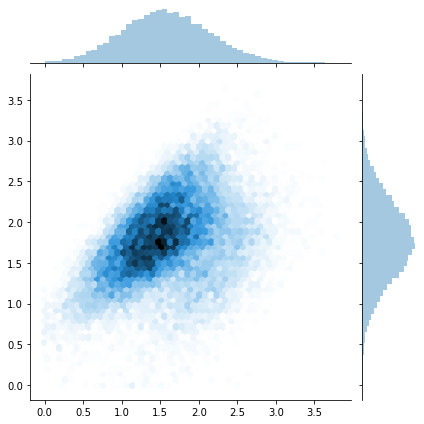

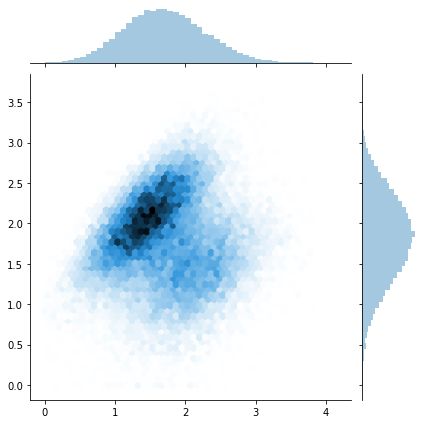

In [115]:
jointPlots( encoded_hh_imgs, encoded_imgs, 0, 10)

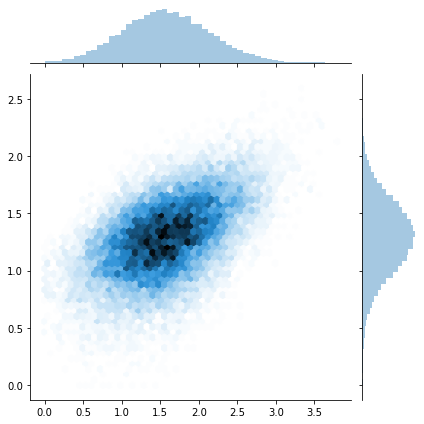

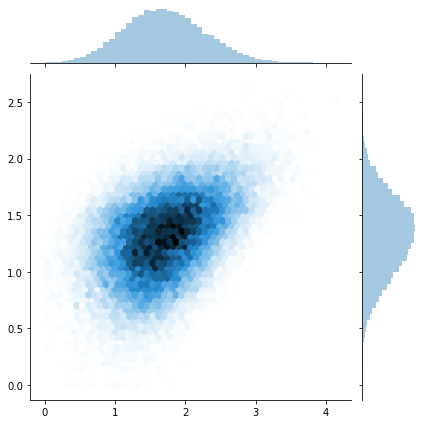

In [116]:
jointPlots( encoded_hh_imgs, encoded_imgs, 0, 8)


In [117]:
print(encoded_imgs.shape, encoded_hh_imgs.shape, labels_hh_test.shape, labels_qcd_test.shape)
# add labels
bdt_data_train_qcd = np.concatenate((encoded_imgs, labels_qcd_test.values), 1)
bdt_data_train_hh  = np.concatenate((encoded_hh_imgs, labels_hh_test.values), 1)
bdt_data_train_all =  np.concatenate((bdt_data_train_qcd, bdt_data_train_hh))  

bdt_data_train, bdt_data_test, bdt_labels_train, bdt_labels_test = train_test_split(np.delete(bdt_data_train_all, -1, axis=1), 
                                                                                    bdt_data_train_all[:,-1], 
                                                                                    test_size=testingFraction, 
                                                                                    shuffle= True, 
                                                                                    random_state=30)

(34884, 15) (23724, 15) (23724, 1) (34884, 1)


In [118]:
#bdt_data_train is the input to use for BDT. borrow structure from k-means study by Ang

In [119]:
def trainBDT(X, y, X_val, y_val, param):

    evallist = [(X, y), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X, y.ravel(), eval_set=evallist, verbose=True, early_stopping_rounds=30)
    results = model.evals_result()
    ypred = model.predict(X_val)
    predictions = [round(value) for value in ypred]
    accuracy = accuracy_score(y_val, predictions)
    print("The training accuaracy is: {}".format(accuracy))
    conf_matrix = confusion_matrix(y_val, predictions)
    print("The confusion matrix: {}".format(conf_matrix))
    print("The precision is: {}".format(precision_score(y_val, predictions)))
    plot_BDTScore(X_val.copy(), y_val.copy(), model)
    return



In [137]:
param_softprob = {
    'eta': 0.1,
    'n_estimators': 300,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'mlogloss',
    #'objective': 'binary:logistic',
    'objective': 'multi:softprob',
    'num_class': 2,
    'random_state': 27
}

param = {
    'eta': 0.1,
    'n_estimators': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 6,
    'scale_pos_weight': 1,
    #'eval_metric': 'auc',
    #'eval_metric': 'loss',
    'objective': 'binary:logistic',
    'random_state': 27
}

In [138]:
#trainBDT(bdt_data_train.copy(), bdt_labels_train.copy(), bdt_data_test.copy(), bdt_labels_test.copy(), param_softprob)

In [141]:
def setupAndTrainBDT(param, _data_train, _labels_train, _data_test, _labels_test, _testSize=0.3, _saveModel=False):
    """setup and train BDT"""
    
    D_train = xgb.DMatrix(_data_train, label=_labels_train)
    D_test  = xgb.DMatrix(_data_test, label=_labels_test)
    
    # *** 2. Define XGB model 
    
    steps = 300  # The number of training iterations

    # *** 3. Train model    
 
    #evallist = [(X, y), (X_val, y_val)]
    #model = xgb.XGBClassifier(**param)
    #model.fit(X, y.ravel(), eval_set=evallist, verbose=True, early_stopping_rounds=30)

    #model = xgb.train(param, D_train, steps, evals=[(D_test, 'loss')], early_stopping_rounds=50)
    model = xgb.train(param, D_train, steps, evals=[(D_test, 'loss')], early_stopping_rounds=50)

    #ang
    #evallist = [(data_train, label_train), (data_test, label_test)]
    #model = xgb.XGBClassifier(**param)
    #model.fit(data_train, label_train.ravel(), eval_set=evallist, verbose=True, early_stopping_rounds=30)

    # *** 4A. Ang    
    #results = model.evals_result()
    #ypred = model.predict(data_test)
    #predictions = [round(value) for value in ypred]
    #accuracy = accuracy_score(label_test, predictions)
    #print("The training accuaracy is: {}".format(accuracy))
    ##conf_matrix = confusion_matrix(y_val, predictions)
    ##print("The confusion matrix: {}".format(conf_matrix))
    #print("The precision is: {}".format(precision_score(label_test, predictions)))

    #plot_BDTScore(data_test.copy(), label_test.copy(), model)
        
    # *** 4. Evaluate model
    preds = model.predict(D_test)
    #preds = model.predict( (data_test, label_test) )
    print(preds)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(_labels_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(_labels_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(_labels_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    
    return model



def plotBDTOutputAndTree(_model, _data_test, _labels_test, _savePlots=False):
    """make plots of BDT outputs for signal+background probabilities and tree plot"""
    _labels_test = np.array([[x] for x in _labels_test])

    # *** 0. Split by signal and background
    #_signalData = np.asarray([x for x,y in zip(_data_test, _labels_test)) if y[0] == 1])
    #_bkgData    = np.asarray([x for x,y in zip(_data_test, _labels_test)) if y[0] == 0])    
    #_signalLabels = np.asarray([x for x in _labels_test if x[0] == 1])
    #_bkgLabels    = np.asarray([x for x in _labels_test if x[0] == 0])
    
    _signalData = np.asarray([x for x,y in zip(_data_test, _labels_test) if y == 1])
    _bkgData    = np.asarray([x for x,y in zip(_data_test, _labels_test) if y == 0])    
    _signalLabels = np.asarray([x for x in _labels_test if x == 1])
    _bkgLabels    = np.asarray([x for x in _labels_test if x == 0])
    
    # *** 1. Make some 1D histograms of signal decision outputs
    signal_DMatrix = xgb.DMatrix(_signalData, label=_signalLabels)
    preds_signal = _model.predict(signal_DMatrix)
    sig_pred_isBkg     = [x for x in preds_signal]
    sig_pred_isSignal  = [x for x in preds_signal]
    #plt.hist(preds_hh)
    
    # *** 2. Make some 1D histograms of background decision outputs
    bkg_DMatrix = xgb.DMatrix(_bkgData, label=_bkgLabels)
    preds_bkg = _model.predict(bkg_DMatrix)
    bkg_pred_isBkg    = [x for x in preds_bkg]
    bkg_pred_isSignal = [x for x in preds_bkg]
    #plt.hist(preds_qcd)
    
    # *** 3. Plot feature importance
    _modelName = 'BDT'
    if(_savePlots):
        xgb.plot_importance(_model)
        _fig = plt.gcf()
        _scope    = _modelName.split(' ')[0].lower()
        _variable = 'featureImportance'
        _filename  = _scope + '_' + _variable
        _fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    # *** 4. Make dict for plotting with borrowed functions
    _nBins = 100
    predictionResults = {'hh_pred_isSignal':sig_pred_isSignal, 'hh_pred_isBkg':sig_pred_isBkg, 'qcd_pred_isSignal':bkg_pred_isSignal, 'qcd_pred_isBkg':bkg_pred_isBkg,}
    compareManyHistograms( predictionResults, ['hh_pred_isSignal', 'qcd_pred_isSignal'], 2, 'Signal Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _normed=True )
    compareManyHistograms( predictionResults, ['hh_pred_isBkg', 'qcd_pred_isBkg'], 2, 'Bkg Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _normed=True )
    xgb.plot_importance(_model)
    

    # *** 6. restore figure defaults
    plt.rcParams['figure.figsize'] = [6.4, 4.8]

    returnBestCutValue('BDT', sig_pred_isSignal.copy(), bkg_pred_isSignal.copy(), _testingFraction=testingFraction*testingFraction, _minBackground=2e5)


    return

[0]	loss-error:0.332196
Will train until loss-error hasn't improved in 50 rounds.
[1]	loss-error:0.315077
[2]	loss-error:0.308195
[3]	loss-error:0.302906
[4]	loss-error:0.297219
[5]	loss-error:0.295342
[6]	loss-error:0.296423
[7]	loss-error:0.293807
[8]	loss-error:0.293181
[9]	loss-error:0.290735
[10]	loss-error:0.289996
[11]	loss-error:0.287607
[12]	loss-error:0.287209
[13]	loss-error:0.285958
[14]	loss-error:0.283569
[15]	loss-error:0.283342
[16]	loss-error:0.282432
[17]	loss-error:0.280953
[18]	loss-error:0.280555
[19]	loss-error:0.27811
[20]	loss-error:0.277029
[21]	loss-error:0.276346
[22]	loss-error:0.274754
[23]	loss-error:0.275664
[24]	loss-error:0.273901
[25]	loss-error:0.273446
[26]	loss-error:0.272763
[27]	loss-error:0.271342
[28]	loss-error:0.271
[29]	loss-error:0.27009
[30]	loss-error:0.269806
[31]	loss-error:0.267702
[32]	loss-error:0.267019
[33]	loss-error:0.266507
[34]	loss-error:0.266564
[35]	loss-error:0.265939
[36]	loss-error:0.266052
[37]	loss-error:0.264574
[38]	lo

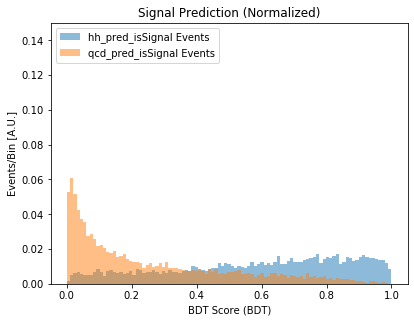

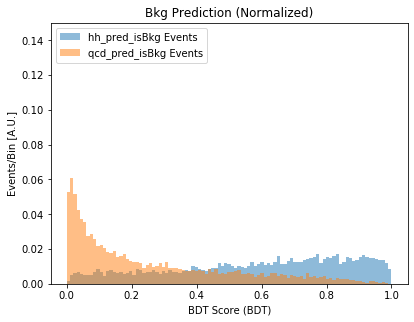

7129 10454
nSig = 3431.14 , nBkg = 10833081.43 with significance = 1.042 +/- 0.021 for BDT score > 0.564


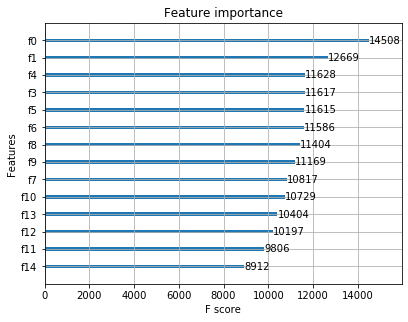

In [142]:
model_ben = setupAndTrainBDT(param, bdt_data_train.copy(), bdt_labels_train.copy(), 
                             bdt_data_test.copy(), bdt_labels_test.copy())
#plot_BDTScore( data_test_norm.copy(), labels_test_np.copy(), model_ben)
plotBDTOutputAndTree(model_ben, bdt_data_test, bdt_labels_test)

In [124]:
#plotBDTOutputAndTree(model_ben, bdt_data_test, bdt_labels_test)